In [1]:
import polars as pl
import polars.selectors as cs
import orjson
import numpy as np
import scipy.stats as sp
from cachetools import cached, TTLCache


@cached(TTLCache(maxsize=2048, ttl=600))
def sacred_to_df(sacred_logfile: str)-> pl.DataFrame:
    try:
        with open(sacred_logfile, "r") as f:
            data: dict[str, list] = orjson.loads(f.read())
    except orjson.JSONDecodeError as e:
        raise RuntimeError(f"Error while parsing {sacred_logfile}: {e}")

    res = dict[str, list]()
    length = 0
    for key, values in data.items():
        length = max(length, len(values))
        new_values = list[float]()
        for v in values:
            match v:
                case float() | int():
                    new_values.append(v)
                case dict():
                    if "py/reduce" in v:
                        # Ignore this
                        continue
                    dtype = v.get("dtype", None)
                    if dtype is None:
                        raise NotImplementedError(f"Unknown dtype: {v}")
                    match v["dtype"]:
                        case "float64":
                            new_values.append(float(v["value"]))
                        case _:
                            raise NotImplementedError(f"Unknown dtype: {v['dtype']}")
                case _:
                    raise NotImplementedError(f"Unknown: {v}")
        if len(new_values) > 0:
            if "return" in key or "episode" in key:
                continue
            key = key.replace("_", "-")
            res[key] = new_values

    # When the algorithm is still training, it is possible to have different lengths.
    # In that case, we pad the shorter ones with the last value.
    maxlen = max(len(v) for v in res.values())
    for key, values in res.items():
        if len(values) < maxlen:
            res[key] = values + [values[-1]] * (maxlen - len(values))
    df = pl.DataFrame(res)
    df = df.with_columns(pl.col("ep-length-mean-T").alias("time-step"))
    for column in df.columns:
        if column.endswith("-T") or column in ["epsilon"]:
            df = df.drop(column)
        elif column.endswith("-mean"):
            df = df.rename({column: column.replace("-mean", "")})
    return df


def round_col(df: pl.DataFrame, col_name: str, round_value: int):
    col = df[col_name] / round_value
    col = col.round(0)
    col = col * round_value
    col = col.cast(pl.Int64)
    return df.with_columns(col.alias(col_name))


def stats_by(col_name: str, df: pl.DataFrame, replace_inf: bool):
    if len(df) == 0:
        return df
    grouped = df.group_by(col_name)
    cols = [col for col in df.columns if col != col_name]
    res = grouped.agg(
        [pl.mean(col).alias(f"mean-{col}") for col in cols]
        + [pl.std(col).alias(f"std-{col}") for col in cols]
        + [pl.min(col).alias(f"min-{col}") for col in cols]
        + [pl.max(col).alias(f"max-{col}") for col in cols]
    ).sort(col_name)

    # Compute confidence intervals for 95% confidence
    # https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy
    confidence_intervals = []
    counts = grouped.len().sort(col_name)["len"]
    scale = (counts**0.5).to_numpy().astype(np.float32)
    for col in cols:
        mean = res[f"mean-{col}"].to_numpy().astype(np.float32)
        # Avoid zero std with +1e-8, otherwise a "inf" * 0 will be computed by scipy, leading to NaN
        std = res[f"std-{col}"].to_numpy().astype(np.float32) + 1e-8
        # Use scipy.stats.t if the sample size is small (then degree of freedom, df, is n_samples - 1)
        # Use scipy.stats.norm if the sample size is large
        lower, upper = sp.norm.interval(0.95, loc=mean, scale=std / scale)
        plus95 = pl.Series(name=f"{col}-plus95", values=upper)
        minus95 = pl.Series(name=f"{col}-minus95", values=lower)
        confidence_intervals += [plus95, minus95]

    res = res.with_columns(confidence_intervals)
    if replace_inf:
        for series in res.select(cs.float()):
            mask = series.is_infinite() | series.is_nan()
            series[mask] = 0
            res = res.with_columns(series)
    return res


# Transform Sacred to CSV

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np

ALIAS = {
    "lle_6_vdn_gamma0.95": "VDN",
    "lle_6_qmix_gamma0.95": "QMIX",
    "lle_6_haven-vdn": "Haven (VDN)",
    "lle_6_haven-qmix": "Haven (QMix)",
    "shaped_lle_6_vdn": "VDN shaped",
    "shaped_lle_6_qmix": "QMix shaped",
    "shaped_lle_6_haven-cnn-vdn-no-ir-no-shaped-subgoals": "VDN-SL",
    "shaped_lle_6_haven-vdn": "Haven shaped",
    "lle_6_haven-cnn-vdn-no-ir": "VDN-NL",
    "shaped_lle_6_haven-cnn-vdn-no-subgoal-no-shaped-reward": "VDN-IG",
    "lle_6_haven-cnn-vdn-no-subgoal": "VDN-IN",
    "lle_6_haven-cnn-vdn-no-subgoal-value-potential": "VDN-IN Value Potential",
    "shaped_lle_6_vdn-no-shaped-subgoals": "VDN-SN",
    "shaped_lle_6_vdn-no-shaped-reward": "VDN-NG",
    "lle_6_maser-vdn": "MASER",
    "lle_6_qplex": "QPLEX",
}

METRICS = {
    "test-exit-rate": "Exit rate",
    "test-ep-length": "Episode length",
}

COLOURS = {
    "VDN": "tab:blue",
    "QMIX": "tab:green",
    "Haven (VDN)": "tab:red",
    "Haven (QMix)": "tab:orange",
}


def get_df(folder: str, min_n_steps: int | None = None) -> pl.DataFrame:
    dfs = []
    subfolders = sorted([s for s in os.listdir(folder) if s.isnumeric()], key=int)
    subfolders = [os.path.join(folder, s) for s in subfolders]
    subfolders = [s for s in subfolders if os.path.isdir(s)]
    for subfolder in subfolders:
        file = os.path.join(subfolder, "info.json")
        if not os.path.exists(file):
            print(file, "does not exist")
            continue
        new_df = sacred_to_df(file)
        if len(dfs) > 0:
            new_cols = set(new_df.columns)
            current_cols = set(dfs[0].columns)
            if not current_cols.issubset(new_cols):
                print(f"Columns mismatch: {new_df.columns} != {dfs[0].columns}")
                missing_cols = current_cols - new_cols
                extras_cols = new_cols - current_cols
                raise ValueError(f"Columns mismatch between {subfolder} and {subfolders[0]}.\nMissing: {missing_cols}\nExtras: {extras_cols}")
            if len(new_cols) > len(current_cols):
                extras = new_cols - current_cols
                print(f"Ignoring columns: {extras}")
                new_df = new_df.drop(extras)
        if len(new_df) > 0:
            if min_n_steps is None:
                add = True
            else:
                add = new_df["time-step"].max() >= min_n_steps  # type: ignore
            if add:
                dfs.append(new_df)
        else:
            print(f"Empty {file}")
    print(f"There are {len(dfs)} dataframes for {ALIAS.get(folder, folder)}")
    df = pl.concat(dfs)
    return df


def plot(
    folders: list[str],
    metrics: list[str] | None = None,
    min_n_steps: int | None = None,
    save_name: str | None = None,
    legend_pos: str = "best",
    dimensions: tuple[int, int] = (10, 5),
):
    dfs = []
    for folder in folders:
        dfs.append(get_df(folder, min_n_steps))

    if metrics is None:
        metrics = [col for col in dfs[0].columns if col != "time-step"]
    dfs = [round_col(df, "time-step", 5_000) for df in dfs]
    dfs = [stats_by("time-step", df, True) for df in dfs]

    for metric in metrics:
        plt.figure(figsize=dimensions)
        if metric in ["td-error", "loss", "target", "td-error-abs"]:
            continue
        for folder, df in zip(folders, dfs):
            # print(label, sorted(df.columns))
            cols = [f"{metric}-minus95", f"min-{metric}", f"mean-{metric}", f"max-{metric}", f"{metric}-plus95"]
            missing = False
            for col in cols:
                if col not in df.columns:
                    missing = True
                    print(f"Missing {col} in {folder}")
            if not missing:
                minimum = np.array([df[f"{metric}-minus95"], df[f"min-{metric}"]]).max(axis=0)
                mean = df[f"mean-{metric}"]
                maximum = np.array([df[f"{metric}-plus95"], df[f"max-{metric}"]]).min(axis=0)
                # colour = COLOURS.get(ALIAS.get(folder, folder), None)
                plt.plot(df["time-step"], mean, label=ALIAS.get(folder, folder))
                plt.fill_between(df["time-step"], minimum, maximum, alpha=0.4)
        plt.tight_layout()
        plt.legend(loc=legend_pos)
        plt.xlabel("Time steps")
        plt.ylabel(METRICS.get(metric, metric))
        if save_name is not None:
            plt.savefig(f"{save_name}_{metric}.svg")
        else:
            plt.title(metric)
        plt.show()
        plt.clf()


# Baselines: VDN, QMix, Haven & MASER

There are 18 dataframes for MASER
There are 20 dataframes for VDN
There are 25 dataframes for Haven (VDN)
There are 20 dataframes for QMIX
There are 17 dataframes for Haven (QMix)


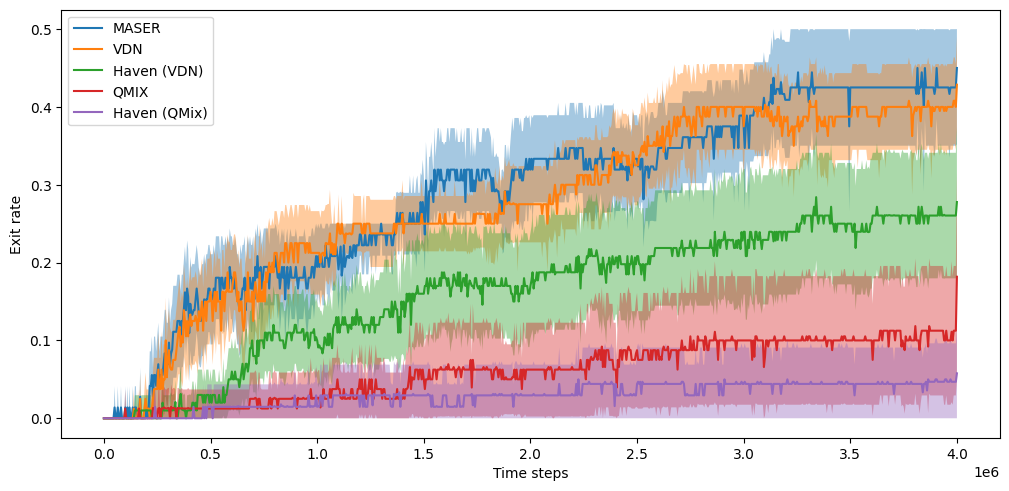

<Figure size 640x480 with 0 Axes>

In [14]:
folders = [
    "lle_6_maser-vdn",
    "lle_6_vdn_gamma0.95",
    "lle_6_haven-vdn",
    "lle_6_qmix_gamma0.95",
    "lle_6_haven-qmix",
]
plot(folders, metrics=["test-exit-rate"], save_name="baseline", min_n_steps=2_000_000)

# Potential shaping vs baselines

Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
There are 15 dataframes for VDN shaped
shaped_lle_6_qmix/4/info.json does not exist
shaped_lle_6_qmix/10/info.json does not exist
shaped_lle_6_qmix/11/info.json does not exist
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
There are 24 dataframes for QMix shaped
There are 40 dat

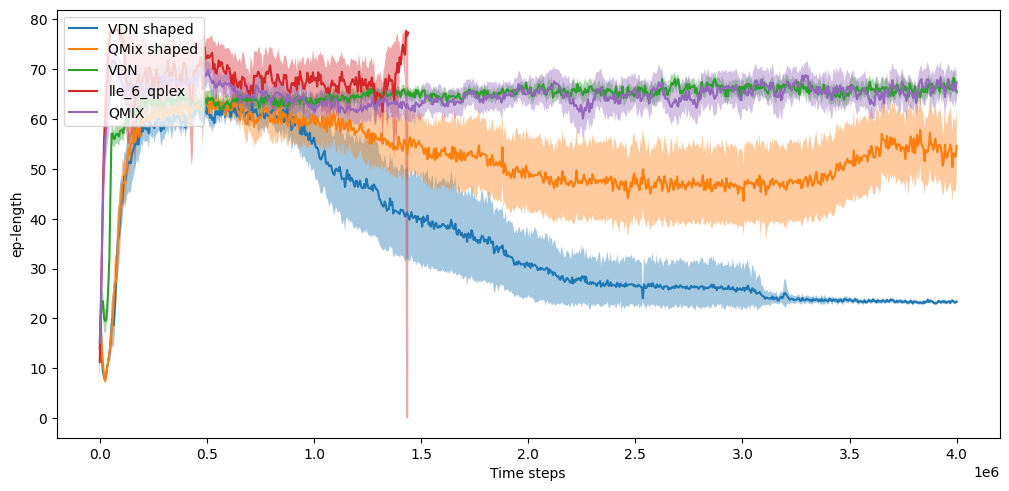

<Figure size 640x480 with 0 Axes>

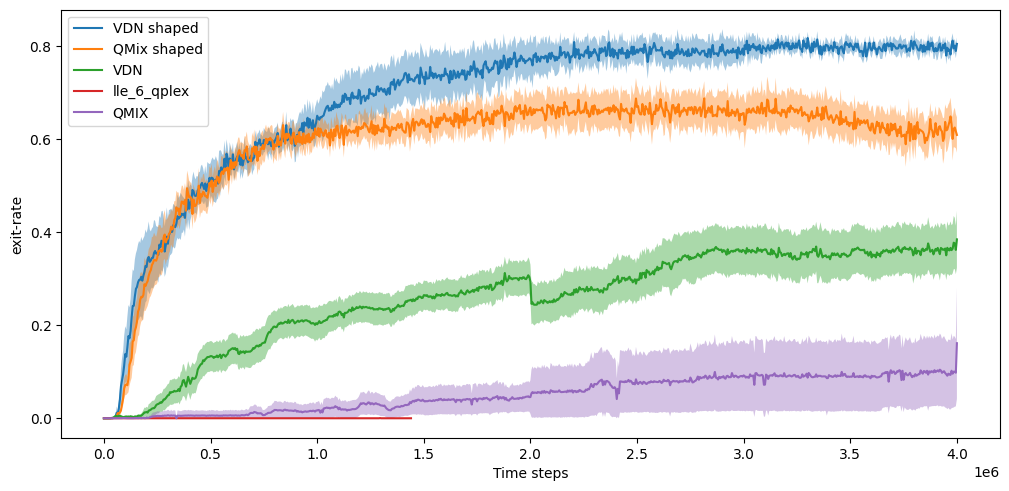

<Figure size 640x480 with 0 Axes>

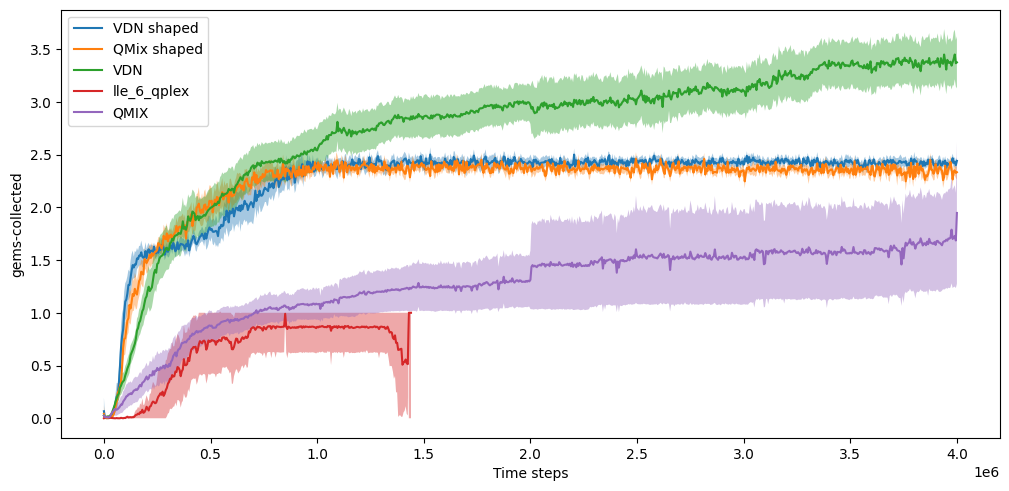

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

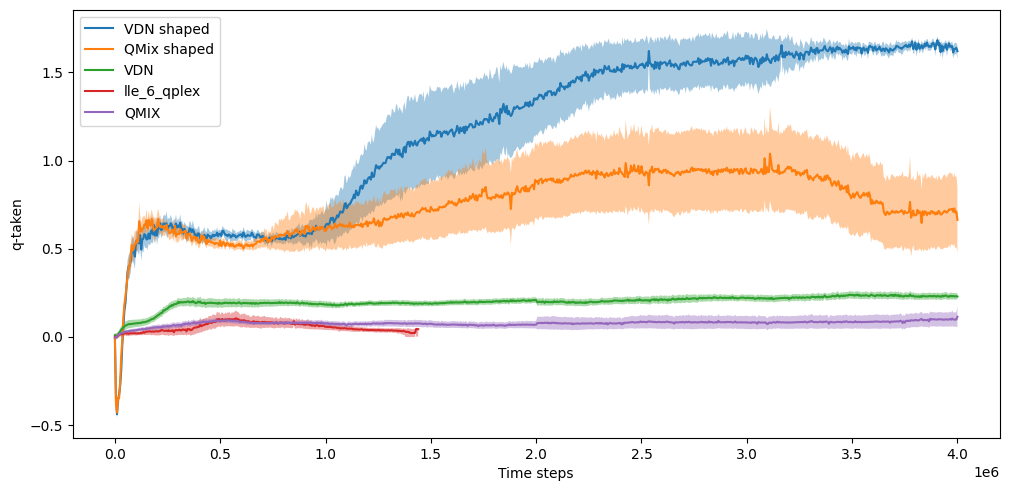

<Figure size 640x480 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

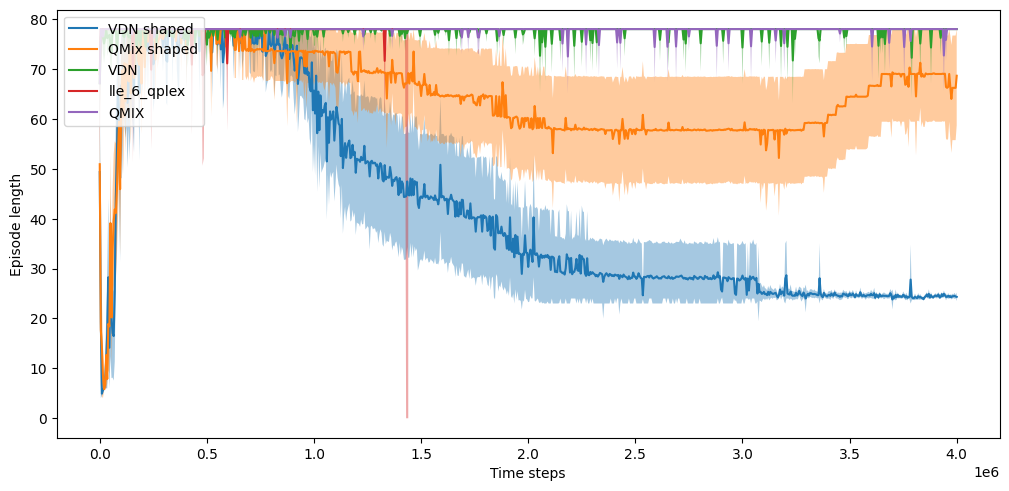

<Figure size 640x480 with 0 Axes>

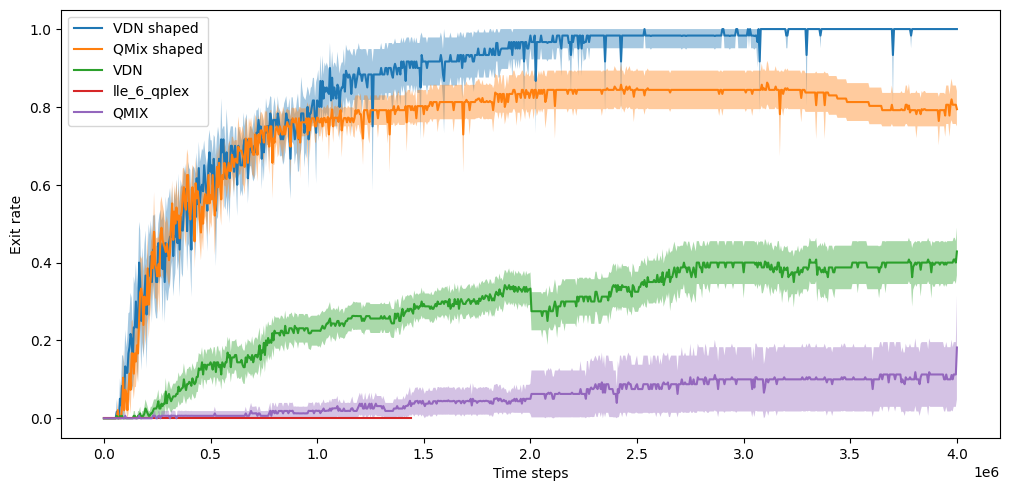

<Figure size 640x480 with 0 Axes>

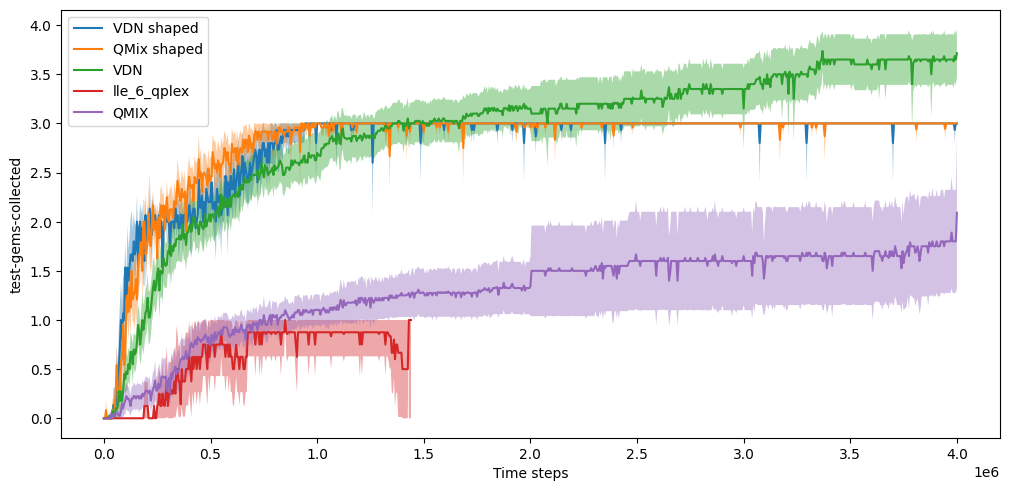

<Figure size 640x480 with 0 Axes>

In [ ]:
folders = [
    "shaped_lle_6_vdn",
    # "shaped_lle_6_vdn-no-shaped-subgoals",
    #"shaped_lle_6_qmix-no-shaped-subgoals",
    "shaped_lle_6_qmix",
    "lle_6_vdn_gamma0.95",
    "lle_6_qplex",
    "lle_6_qmix_gamma0.95"
]
plot(folders, metrics=["test-exit-rate", "test-ep-length", ], legend_pos="upper left", save_name="shaping")

### Discussion
As shown in the above plots, adding shaped rewards and shaped subgoals to the agents enables them to complete the collaborative task. This shaped version comprises two key components:
- A shaped reward signal (with potential shaping $F(s, a, s') = \gamma \phi(s') - \phi(s)$
- A shaped subgoal signal, i.e. an encoding of which agent has already reached which subgoal.

The shaped subgoal signal explicitely encodes whether agents have reached their subgoals. In LLE, these subgoals are the bottlenecks of the environment.

# Link with Haven's approach
We identify that Haven is based on two components that are comparable to the potential shaping approach but that these components have to be learned rather than being given directly in the problem statement (i.e. the environment):
- Haven has an intrinsic reward signal defined as the advantage of the action taken 
$$A(s, a) = R(s, a, s') + \gamma V(s') - V(s) \approx F(s, a, s')$$
- Haven is a hierachical method where the meta-agent gives "orders", i.e. subgoals, to the worker agents. The meta-agent learns to give the right subgoals to the right agents. This is similar to the extra information given to the agents in the shaped version.
$$ \text{extras} = \text{subgoals} $$

Since, as shown in the previous plots, VDN and QMix are able to complete the task with potential shaping, we train the agents with Haven and check if the meta-agent is able to learn the subgoals and the intrinsic reward signal.

## Shaping vs Haven

Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
There are 7 dataframes for VDN shaped
There are 20 dataframes for VDN
There are 24 dataframes for Haven (VDN)
There are 17 dataframes for Haven (QMix)


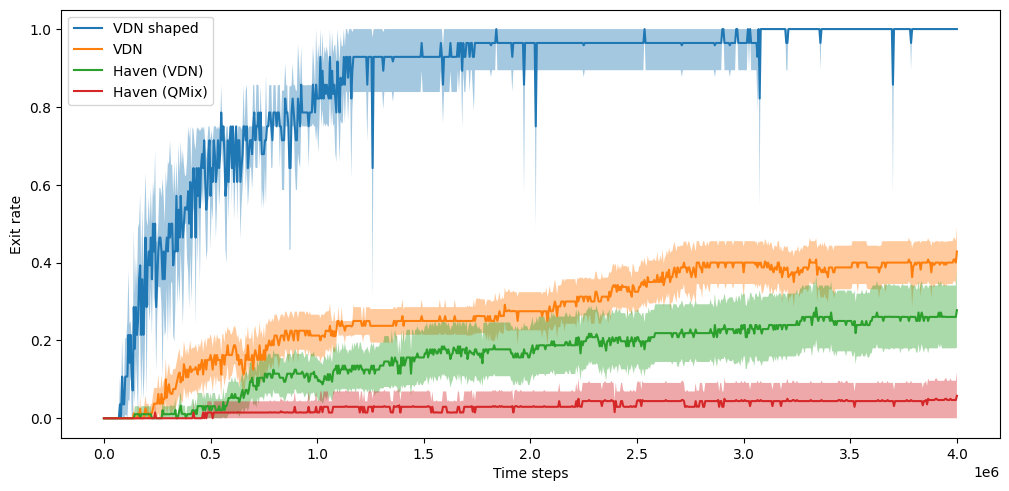

<Figure size 640x480 with 0 Axes>

In [5]:
folders = [
    "shaped_lle_6_vdn",
    "lle_6_vdn_gamma0.95",
    "lle_6_haven-vdn",
    "lle_6_haven-qmix"
]
plot(folders, metrics=["test-exit-rate"], min_n_steps=3_000_000, save_name="haven")

### Discussion
As shown in the previous plot, Haven is far from reaching the same performance as the potential shaped version.

# Ablation study
To identify what Haven is capable of learning or not, we perform an ablation study to identify what Haven can bring to the table.

We identify the following combinations:

| Title             | Extra reward       | Subgoals         | Done |
| ------------------| ------------------ | ---------------- | ---- |
| VDN               | None               | None             | Yes  |
| VDN shaped        | Shaped             | Given            | Yes  |      
| Haven             | Intrinsic          | Learned          | Yes  |
| VDN-IG            | Intrinsic          | Given            | Yes  |
| VDN-IN            | Intrinsic          | None             | Yes  |
| VDN-SL            | Shaped             | Learned          | Yes  |
| VDN-SN            | Shaped             | None             | Yes  |
| VDN-NL            | None               | Learned          | Yes  |
| VDN-NG            | None               | Given            | Yes |
| Haven shaped      | Intrinsic & Shaped | Given & Leanred  | Yes  |


## Impact of subgoals
- VDN-NG
- VDN-NL
- VDN
Conclusion: 

There are 20 dataframes for VDN
There are 8 dataframes for VDN-NL
There are 7 dataframes for VDN-NG


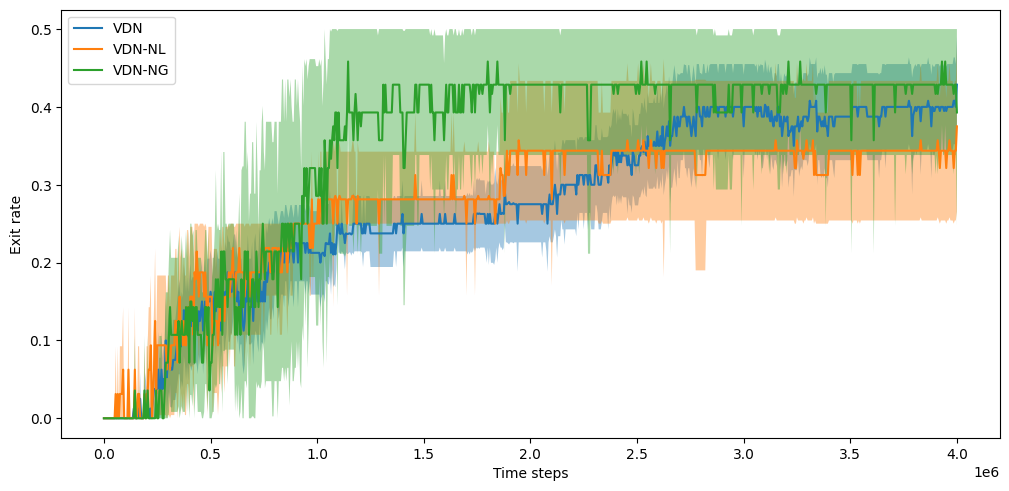

<Figure size 640x480 with 0 Axes>

In [10]:
plot(
    folders=[
        "lle_6_vdn_gamma0.95",  # VDN
        "lle_6_haven-cnn-vdn-no-ir",  # VDN-NL
        "shaped_lle_6_vdn-no-shaped-reward" # VDN-NG
    ],
    metrics=["test-exit-rate"],
    min_n_steps=3_000_000,
    save_name="subgoals",
)

## Impact of potential shaping
- VDN-SN
- VDN-IN
- VDN

There are 8 dataframes for VDN-SN
There are 20 dataframes for VDN
There are 8 dataframes for VDN-IN


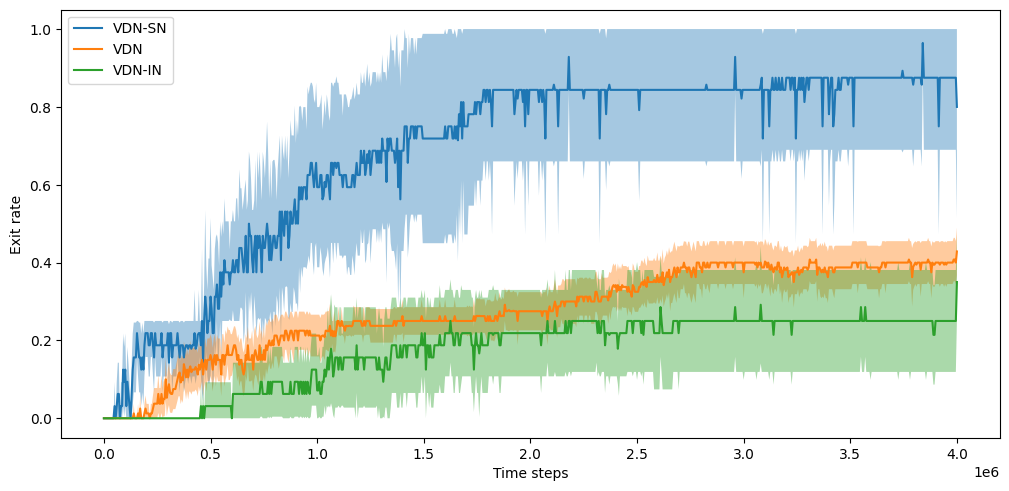

<Figure size 640x480 with 0 Axes>

In [8]:
plot([
    "shaped_lle_6_vdn-no-shaped-subgoals", # VDN-SN
    "lle_6_vdn_gamma0.95", # VDN
    "lle_6_haven-cnn-vdn-no-subgoal" # VDN-IN (Advantage)
], metrics=["test-exit-rate"], min_n_steps=3_000_000, save_name="potential-shaping")

## Impact of both
- VDN shaped 
- VDN-SL
- (VDN-SN added for comparison)
- VDN-IG
- Haven

Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
Ignoring columns: {'grad-norm'}
There are 15 dataframes for VDN shaped
There are 8 dataframes for VDN-SL
There are 8 dataframes for VDN-SN
There are 8 dataframes for VDN-IG
There are 39 dataframes for Haven (VDN)


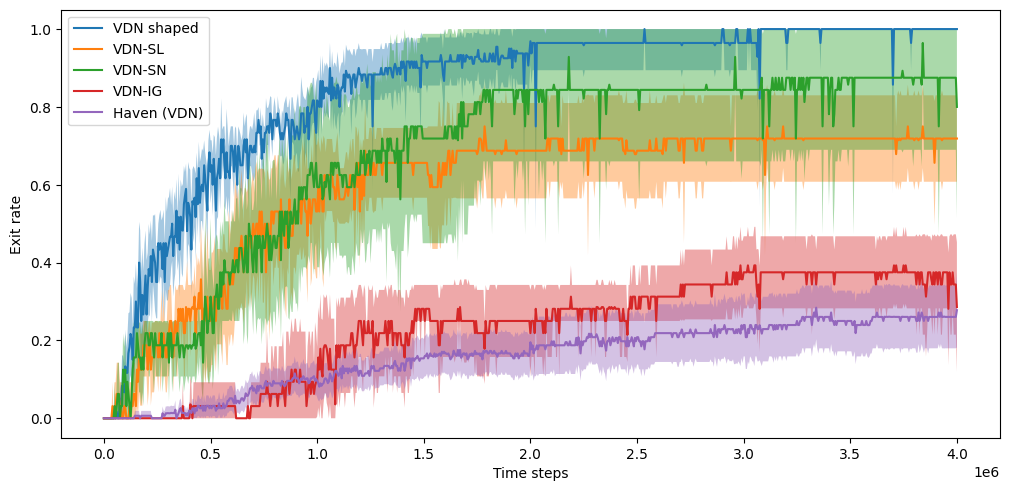

<Figure size 640x480 with 0 Axes>

In [9]:
plot(
    folders=[
        "shaped_lle_6_vdn",
        "shaped_lle_6_haven-cnn-vdn-no-ir-no-shaped-subgoals",
        "shaped_lle_6_vdn-no-shaped-subgoals",
        "shaped_lle_6_haven-cnn-vdn-no-subgoal-no-shaped-reward",
        "lle_6_haven-vdn",
    ],
    metrics=["test-exit-rate"], save_name="both",
)